### Settings

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Timeseries-Forecasting

Mounted at /gdrive
/gdrive/My Drive/Timeseries-Forecasting


In [ ]:
COLAB = False
FIRST_RUN = True
SEED = 42
PLOT = True # display plot
CUT = False # cut the initial timestamps of the timeseries in order to mantain the last N_TIME_STAMPS
N_TIME_STAMPS = 209 # number of time stamps to mantain
WINDOW = 100 # before 30
STRIDE = 10 # before 5
TELESCOPE = 18
BATCH_SIZE = 256
EPOCHS = 200

In [ ]:
# Fix randomness and hide warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(SEED)

import logging

import random
random.seed(SEED)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Data processing

In [ ]:
# Import dataset
data = np.load("training_data.npy")
data.shape

(48000, 2776)

In [ ]:
# Import categories
categories = np.load("categories.npy")
categories.shape
print("Unique categories:")
print(np.unique(categories))

Unique categories:
['A' 'B' 'C' 'D' 'E' 'F']


In [ ]:
# Import valid periods of the time series
valid_periods = np.load("valid_periods.npy")
valid_periods.shape
print(valid_periods[1:5,])
print("Min and max start time: ", min(valid_periods[:,0]), max(valid_periods[:,0]))
print("Min and max end time: ", min(valid_periods[:,1]), max(valid_periods[:,1]))

[[2325 2776]
 [2325 2776]
 [2712 2776]
 [2682 2776]]
Min and max start time:  0 2752
Min and max end time:  2776 2776


In [ ]:
# Count the number of rows(ie timeseries) in each category
print("Number of rows for each category:")
for category in np.unique(categories):
    print(category, np.sum(categories == category))

Number of rows for each category:
A 5728
B 10987
C 10017
D 10016
E 10975
F 277


In [ ]:
# Saving the "strating" indexes of each category
idxs = [0]
cat_order = ["D"]
category = "D"
for i,cat in enumerate(categories):
  if cat != category:
    category = cat
    idxs.append(i)
    cat_order.append(cat)

print("The starting indexes of each category are: ", idxs)
print("The order of each category is: ", cat_order)

The starting indexes of each category are:  [0, 10016, 20991, 26719, 36736, 47723]
The order of each category is:  ['D', 'E', 'A', 'C', 'B', 'F']


In [ ]:
idx=0
category = "B"
for i,cat in enumerate(cat_order):
  if category==cat:
    idx=idxs[i]

In [ ]:
category = "C"
idx = idxs[cat_order.index(category)]

In [ ]:
# print the first n timeseries of a specific category
def plot_rand_time_series(data, categories, category="A", n=5, save=False, show=True):
    data_cat = data[categories==category]
    # exctract n random indices from 0 to len(data_cat)
    indices = np.random.randint(0, len(data_cat), n)

    figs, axs = plt.subplots(len(indices), 1, sharex=True, figsize=(17,2*n))
    for i, idx in enumerate(indices):
        axs[i].plot(data_cat[idx, valid_periods[idx,0] : valid_periods[idx,1]])
        # axs[i].plot(data_cat[idx,:])
        axs[i].set_title(idx)

    if save:
        plt.savefig("plot/" + "TimeSeries" + category + ".pdf", format="pdf")

    # Show the plot
    if not show:
        plt.close()
    else:
        plt.show()

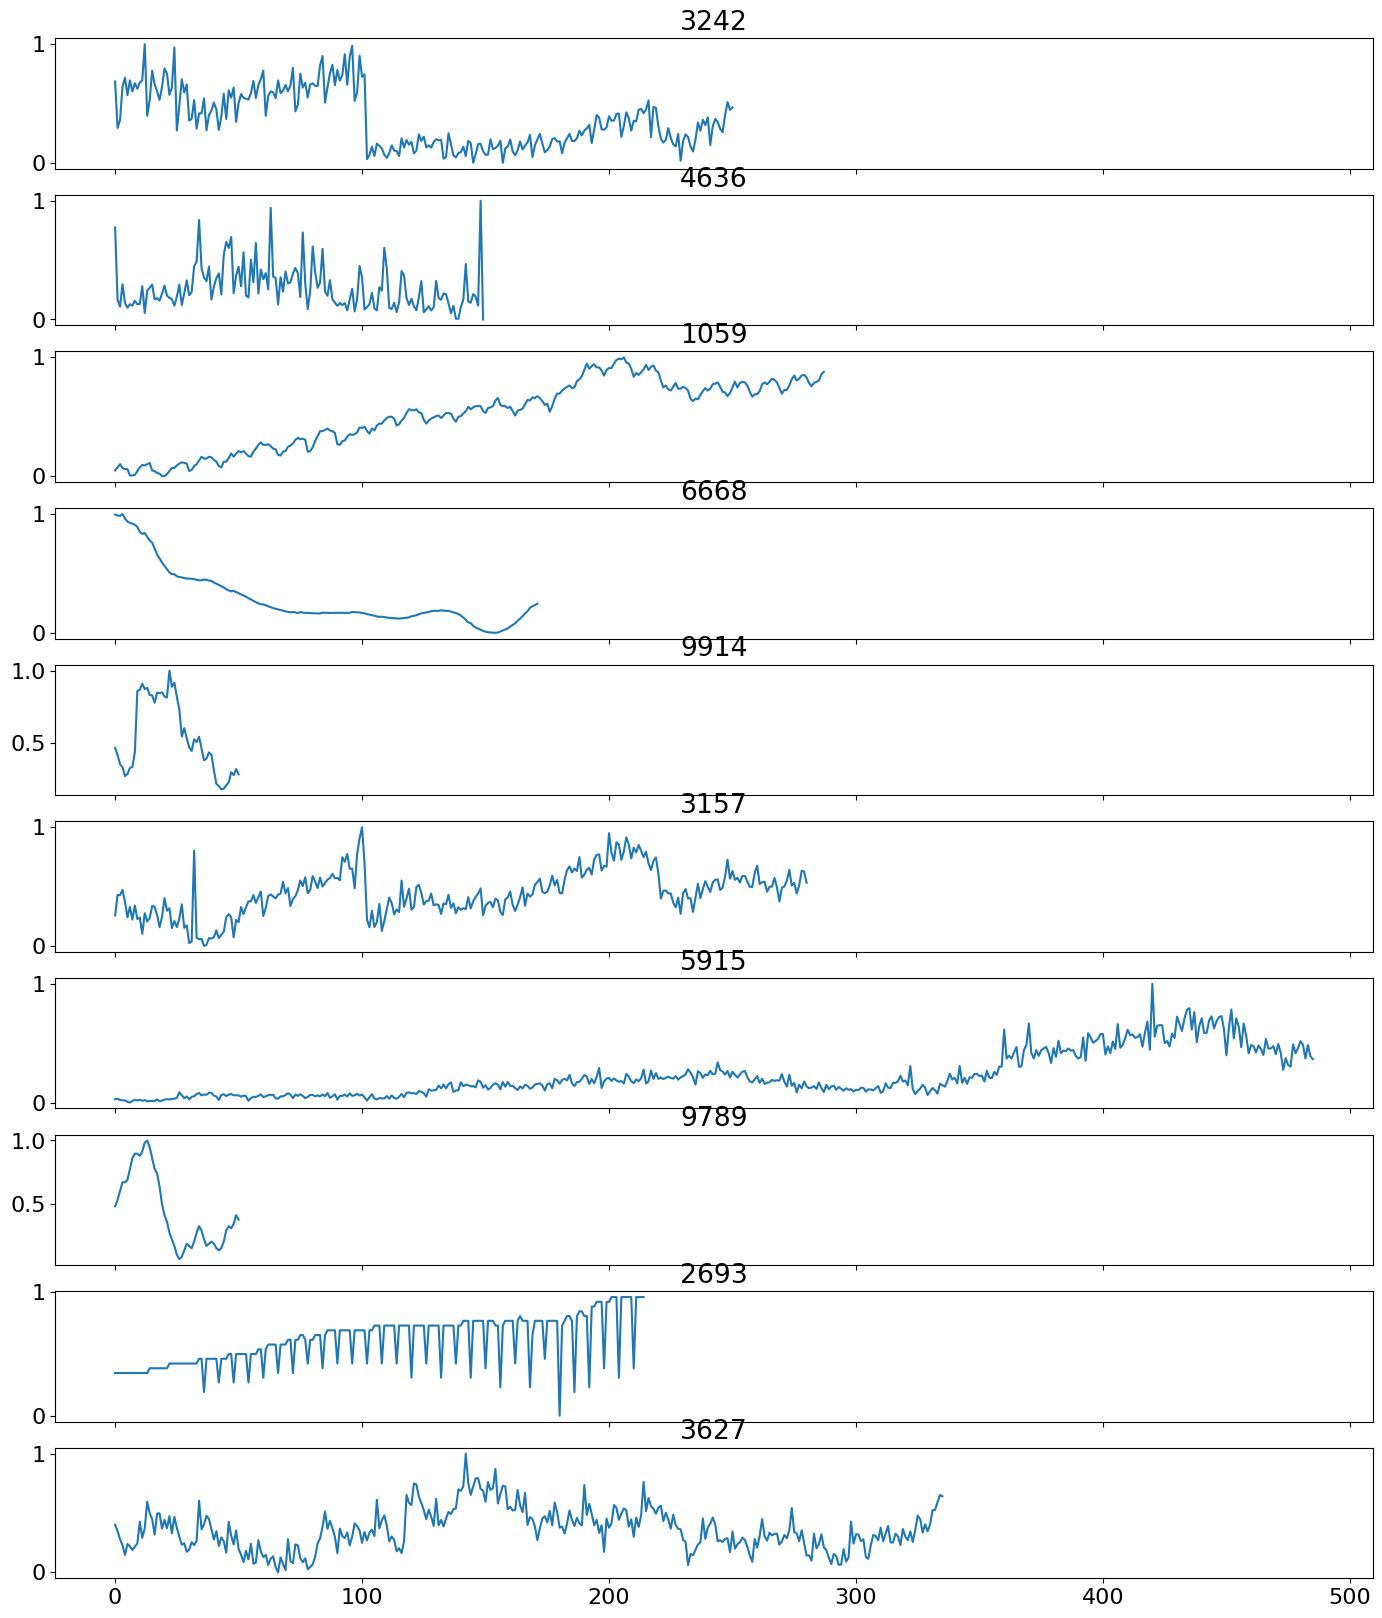

In [ ]:
plot_rand_time_series(data,categories, "D",10, save=True)

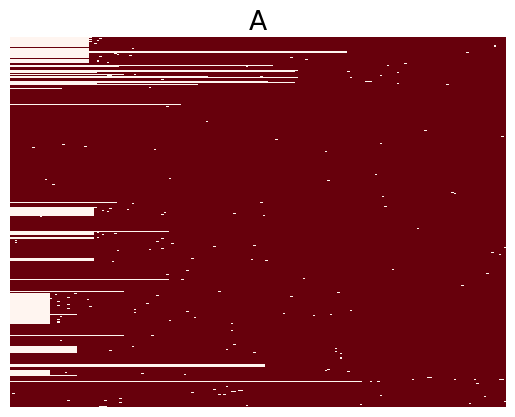

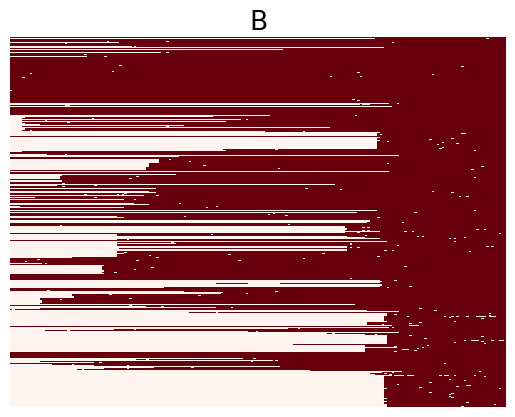

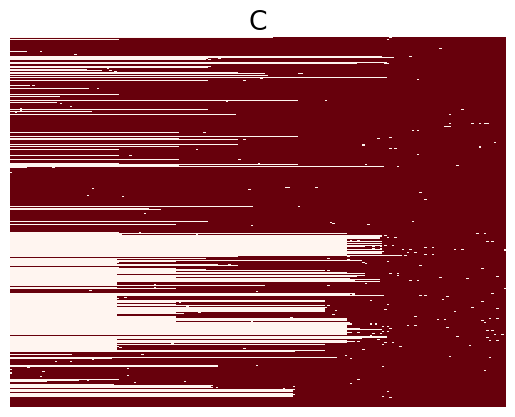

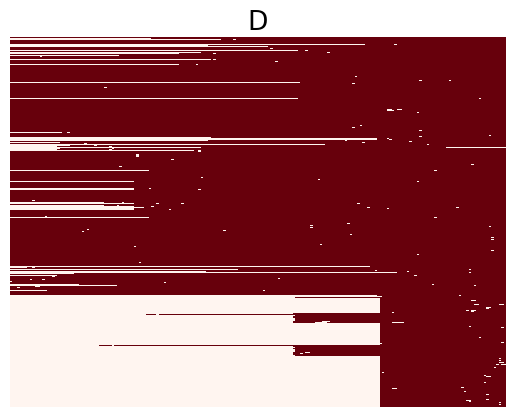

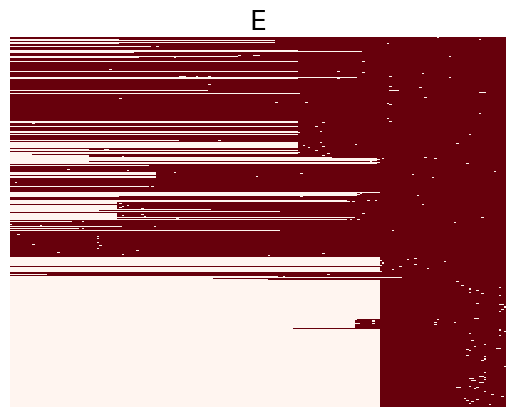

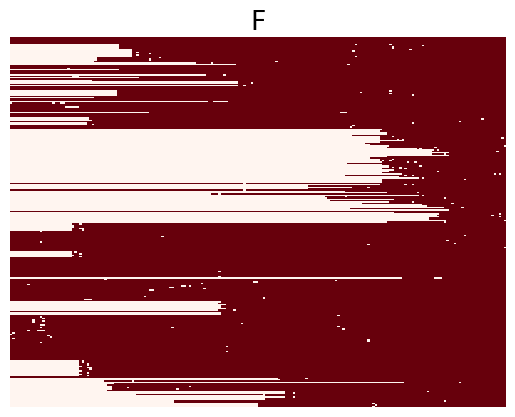

In [ ]:
def plot_matrix(matrix, save=False, show=True, name="data"):
    # Create a binary mask where 1 represents non-zero values
    non_zero_mask = matrix != 0
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Plot non-zero values with one color
    ax.imshow(non_zero_mask, cmap='Reds', aspect='auto', interpolation='none')
    ax.axis('off')
    ax.set_title(name)
    # Show the plot
    if not show:
        plt.close()


# Better to save the image and open the pdf to see all the details
if PLOT:
    # plot_matrix(data, save=True, show=True)
    for category in np.unique(categories):
        plot_matrix(data[categories == category], save=True, show=True, name=category)

In [ ]:
# print n random timeseries of a specific category
def plot_time_series(data, categories, category="A", n=5):
    data_cat = data[categories==category]
    # exctract n random indices from 0 to len(data_cat)
    indices = np.random.randint(0, len(data_cat), n)

    figs, axs = plt.subplots(len(indices), 1, sharex=True, figsize=(17,2*n))
    for i, idx in enumerate(indices):
        # axs[i].plot(data_cat[idx, valid_periods[idx,0] : valid_periods[idx,1]])
        axs[i].plot(data_cat[idx,:])
        # axs[i].plot(data_cat[idx])
        # axs[i].set_title(idx)
    plt.show()

In [ ]:
if PLOT:
    plot_time_series(data, categories, category="B", n=5)

In [ ]:
mean_len = np.mean(valid_periods[:,1] - valid_periods[:,0])
print("Mean length of the time series: ", mean_len)
# reasun why N_TIME_STAMPS is settet to 200

Mean length of the time series:  198.30022916666667


In [ ]:
# cut the data
if CUT:

    # data = data[:,-N_TIME_STAMPS:]
    # if PLOT:
    #     plot_matrix(data)
    # data.shape

    start_time_index = len(data[0]) - N_TIME_STAMPS
    data = data[:,start_time_index:]
    valid_periods = valid_periods - start_time_index
    # set each element of valid_periods[:,0] to 0 if it is negative
    valid_periods[:,0] = np.maximum(valid_periods[:,0], 0)

    print(data.shape)

(48000, 209)


In [ ]:
# convert the data to a pandas dataframe
data = pd.DataFrame(data)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.478704,0.412963,0.501852,0.756481,0.744444,0.640741,0.516667,0.602778,0.367593,0.331481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.628000,0.624000,0.644000,0.688000,0.740000,0.640000,0.536000,0.600000,0.460000,0.396000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.959741,0.949098,0.919297,0.916705,0.901249,0.932531,0.955206,0.960481,0.946506,0.977140
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.411765,0.307030,0.325681,0.361549,0.430416,0.486370,0.450502,0.470588,0.569584,0.571019
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.340909,0.522727,0.568182,0.772727,0.681818,0.704545,0.863636,0.727273,0.818182,0.840909


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [ ]:
# convert all columns to float32
data = data.astype(np.float32)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 200 entries, 0 to 199
dtypes: float32(200)
memory usage: 36.6 MB


In [ ]:
def build_sequences(data, valid_periods, window=WINDOW, stride=STRIDE, telescope=TELESCOPE):
    assert window % stride == 0
    dataset = []
    labels = []
    # iterate over the rows of the dataframe
    for i, time_series in data.iterrows():
        time_series = time_series.values[valid_periods[i][0]:valid_periods[i][1]]
        time_series = np.expand_dims(time_series, axis=-1)


        padding_check = len(time_series)%window # division remainder
        if(padding_check != 0):
            # Compute padding length
            padding_len = window - len(time_series)%window
            padding = np.zeros((padding_len,1), dtype='float32')
            time_series = np.concatenate((padding,time_series))
            assert len(time_series) % window == 0

        for idx in np.arange(0,len(time_series)-window-telescope,stride):
            dataset.append(time_series[idx:idx+window])
            labels.append(time_series[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels



X_train, y_train = build_sequences(data, valid_periods)

In [ ]:
X_train.shape, y_train.shape

((644900, 100, 1), (644900, 18, 1))

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
input_shape, output_shape

((100, 1), (18, 1))

In [ ]:
def learning_rate_schedule(epoch, lr):
    if epoch < 15:
        return lr  # No change for the first 10 epochs
    else:
        return lr * 0.8  # Decrease the learning rate by a factor (e.g., 0.8) after the 15th epoch

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 1)]           0         
                                                                 
 bidirectional_lstm (Bidire  (None, 50, 32)            2304      
 ctional)                                                        
                                                                 
 conv1 (Conv1D)              (None, 50, 128)           12416     
                                                                 
 output_layer (Conv1D)       (None, 50, 1)             385       
                                                                 
 cropping (Cropping1D)       (None, 18, 1)             0         
                                                                 
Total params: 15105 (59.00 KB)
Trainable params: 15105 (59.00 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

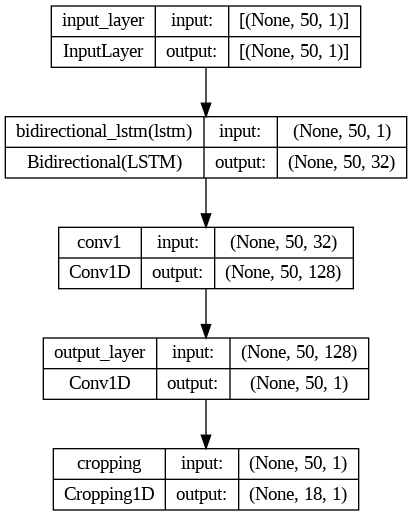

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise, we want input time steps to be >= output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 16 units
    lstm_output = tfkl.Bidirectional(tfkl.LSTM(8, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add an attention mechanism
    attention = tfkl.Attention(use_scale=True, score_mode='concat')([lstm_output, lstm_output])

    # Concatenate the attention output with the LSTM output
    attended_output = tfkl.Concatenate(axis=-1, name='concatenate_attention')([lstm_output, attention])

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv1')(attended_output)


    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

    return model


Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 100, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 100, 16)              640       ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 attention_2 (Attention)     (None, 100, 16)              2         ['bidirectional_lstm[0][0]',  
                                                                     'bidirectional_lstm[0][0]']  
                                                                                    

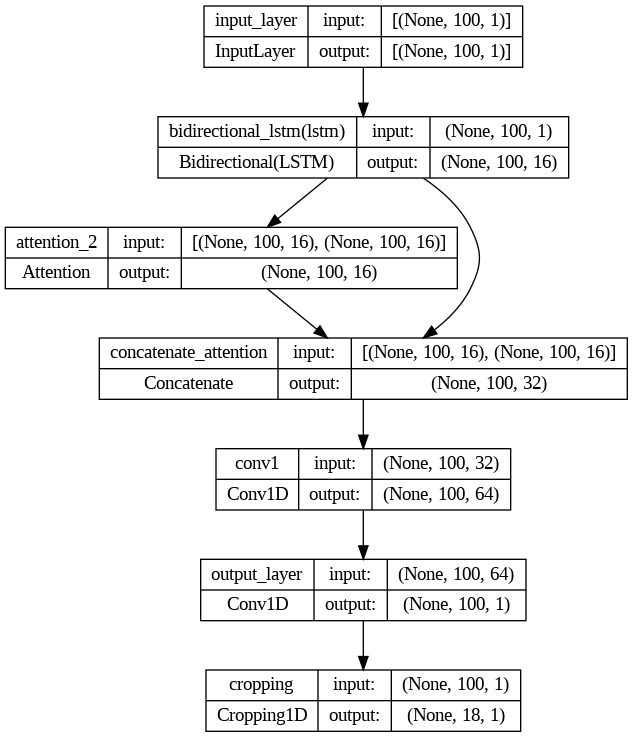

In [ ]:
model1 = build_CONV_LSTM_model(input_shape, output_shape)
model1.summary()
tfk.utils.plot_model(model1, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model1.fit(
    x = X_train,
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split=.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)    ]
).history

Epoch 1/200
2016/2016 [==============================] - 69s 31ms/step - loss: 0.0173 - val_loss: 0.0166 - lr: 0.0100
Epoch 2/200
2016/2016 [==============================] - 61s 30ms/step - loss: 0.0134 - val_loss: 0.0153 - lr: 0.0100
Epoch 3/200
2016/2016 [==============================] - 60s 30ms/step - loss: 0.0126 - val_loss: 0.0152 - lr: 0.0100
Epoch 4/200
2016/2016 [==============================] - 60s 30ms/step - loss: 0.0123 - val_loss: 0.0152 - lr: 0.0100
Epoch 5/200
2016/2016 [==============================] - 61s 30ms/step - loss: 0.0120 - val_loss: 0.0142 - lr: 0.0100
Epoch 6/200
2016/2016 [==============================] - 61s 30ms/step - loss: 0.0119 - val_loss: 0.0142 - lr: 0.0100
Epoch 7/200
2016/2016 [==============================] - 60s 30ms/step - loss: 0.0118 - val_loss: 0.0140 - lr: 0.0100
Epoch 8/200
2016/2016 [==============================] - 65s 32ms/step - loss: 0.0119 - val_loss: 0.0145 - lr: 0.0100
Epoch 9/200
2016/2016 [==============================] -

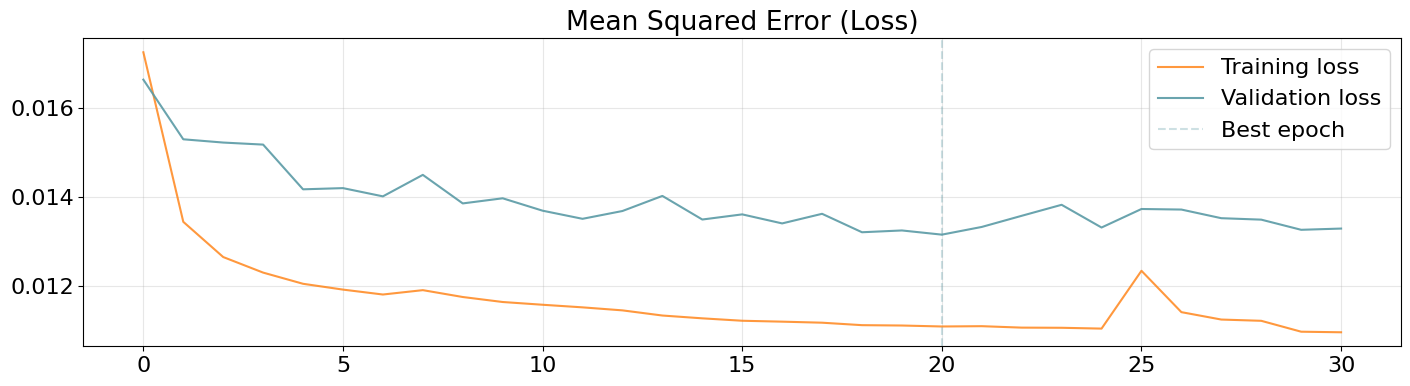

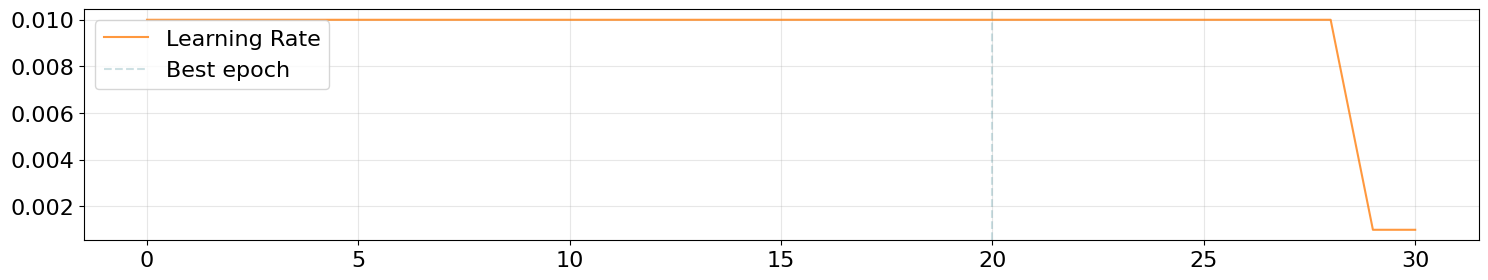

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model1.save("CONV_LSTM_model")
